### Transforms convolutional

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [3]:
# crop size
cihna_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized_and_crop = tf.image.crop_and_resize(images, [cihna_box, flower_box], [0,1], [224,224])

In [4]:
xx=tf.constant([
  [[0, 1, 2, 3, 4],
   [5, 6, 7, 8, 9]],
  [[10, 11, 29, 13, 14],
   [15, 16, 17, 18, 19]],
  [[20, 21, 22, 23, 24],
   [25, 26, 27, 28, 12]]
])
tf.reduce_max(xx).numpy()

29

In [5]:
X = image_resized_and_crop.numpy()
conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3,strides=2,padding='VALID')
output = conv_transpose(X)
output

<tf.Tensor: shape=(2, 449, 449, 5), dtype=float32, numpy=
array([[[[ 4.07178760e-01,  8.14579278e-02, -1.64191961e-01,
          -4.56241099e-03,  5.00102460e-01],
         [ 3.12685192e-01,  6.53147921e-02,  2.91927367e-01,
          -5.19323289e-01, -1.02915727e-01],
         [ 8.38223457e-01,  2.45351344e-01, -4.03118283e-01,
          -1.71644479e-01,  4.23173368e-01],
         ...,
         [ 9.96190131e-01,  3.43563020e-01, -4.33951855e-01,
          -1.63663849e-01,  5.33693910e-01],
         [ 3.32487315e-01,  8.02665129e-02,  3.60796303e-01,
          -6.11086845e-01, -1.17351934e-01],
         [ 5.07919490e-01,  2.15605021e-01, -2.61608839e-01,
          -1.85885921e-01, -6.28959090e-02]],

        [[-1.64093107e-01,  2.66648293e-01, -6.72460496e-02,
          -1.58169672e-01, -4.69391793e-01],
         [-5.26343107e-01, -1.30222842e-01, -3.06469440e-01,
           4.51333411e-02,  1.06240436e-02],
         [ 8.39617848e-03,  6.83164448e-02, -8.48469883e-02,
           3.3546

In [6]:
X.shape

(2, 224, 224, 3)

In [7]:
def normalize(X):
    norm = (X - tf.reduce_min(X) / (tf.reduce_max(X) - tf.reduce_min(X)))
    return norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


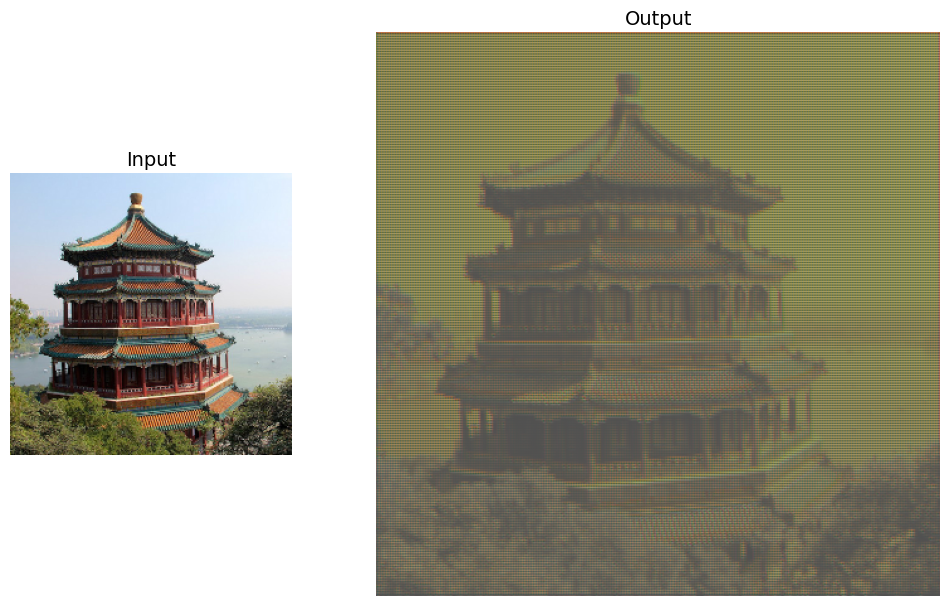

In [8]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [27]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height-1) * stride + 2 * kernel_size-1,
                         (width-1) * stride + 2 * kernel_size -1,
                         channels))
    upscaled[:,# batch size
             kernel_size-1: (height-1) * stride + kernel_size:stride, # height
             kernel_size-1:(width-1) * stride + kernel_size:stride,# width  
             :] = images # channels
    return upscaled

In [29]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis = [0,1]) # flip vertical and horizontal
reversed_filters = np.transpose(reversed_filters,[0,1,3,2])
manual_output = tf.nn.conv2d(upscaled,reversed_filters,strides=1,padding="VALID")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


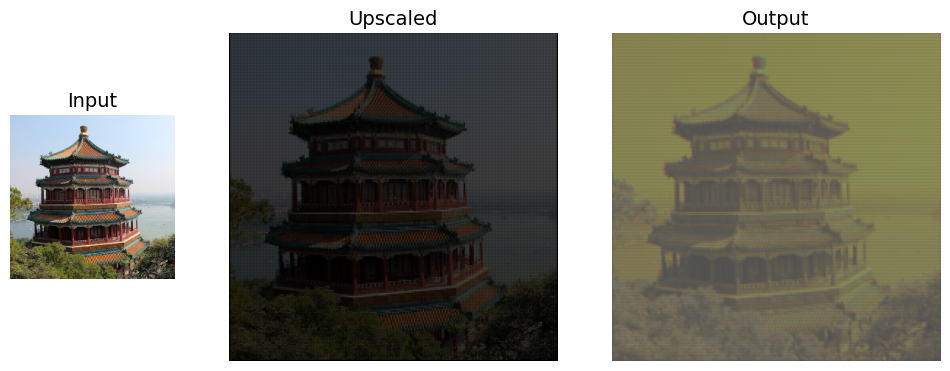

In [30]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()